In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
### Load data
df_path_abun = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/pathways_out/path_abun_contrib.tsv', sep='\t', dtype=str, header=0, usecols=['sample', 'function', 'taxon', 'taxon_abun', 'taxon_function_abun'])
df_tax = pd.read_csv('~/Thesis/data/tax_complete_qiime.txt', sep='\t', dtype=str, header=None, names=['taxon', 'taxonomy'])
df_meta = pd.read_csv('~/Thesis/data/metadata.txt', sep='\t', dtype=str, header=0, usecols=['Barcode ', 'ReactorID', 'SampleDate'])
df_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/KO_metagenome_out/weighted_nsti.tsv', sep='\t', dtype=str, header=0)

# Remove invisible spacings
df_path_abun['sample'] = df_path_abun['sample'].str.strip()

In [5]:
### Save files
df_path_abun.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_path_abun.tsv', sep='\t', index=False)
df_tax.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_tax.tsv', sep='\t', index=False)
df_meta.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_meta.tsv', sep='\t', index=False)
df_nsti.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_nsti.tsv', sep='\t', index=False)

In [6]:
# Filter for PR1 and PR4
barcodes = df_meta[df_meta['ReactorID'].isin(['PR1', 'PR4'])]['Barcode '].tolist()
df_path_abun = df_path_abun[df_path_abun['sample'].isin(barcodes)].copy()

PR1 = df_meta[df_meta['ReactorID'].isin(['PR1'])]['Barcode '].tolist()
PR4 = df_meta[df_meta['ReactorID'].isin(['PR4'])]['Barcode '].tolist()

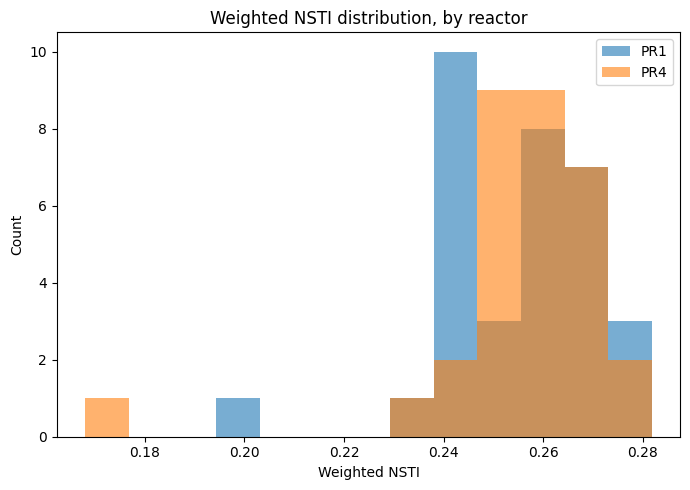

In [7]:
### Weighted NSTI distribution

# Numeric values
df_nsti['weighted_NSTI'] = pd.to_numeric(df_nsti['weighted_NSTI'], errors='coerce').copy()


# Generate boolean masks for PR1 and PR4
mask_pr1 = df_nsti['sample'].isin(PR1)
mask_pr4 = df_nsti['sample'].isin(PR4)

# Common bins for both groups
all_vals = df_nsti.loc[mask_pr1 | mask_pr4, 'weighted_NSTI'].dropna().values
bins = np.histogram_bin_edges(all_vals, bins='auto') if len(all_vals) else 20

# Histogram of weighted NSTI values
plt.figure(figsize=(7, 5))
plt.hist(df_nsti.loc[mask_pr1, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR1', density=False)
plt.hist(df_nsti.loc[mask_pr4, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR4', density=False)
plt.xlabel('Weighted NSTI')
plt.ylabel('Count')
plt.title('Weighted NSTI distribution, by reactor')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
### Compute genus-level pathway abundances

# Pathways of interest
pathways = ['METH-ACETATE-PWY', # Acetoclastic methanogenesis
            'METHANOGENESIS-PWY'] # Hydrogenotrophic methanogenesis


# Keep what's needed
df = df_path_abun[['sample', 'function', 'taxon', 'taxon_function_abun']].copy()


# Ensure numeric abundance
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0.0)


# Fix whitespacing
df_tax["taxon"] = df_tax["taxon"].str.strip()
df_tax["taxonomy"] = df_tax["taxonomy"].str.strip()


# Merge taxonomy onto pathway abundance data
df = df.merge(df_tax, on='taxon', how='left').copy()


# Split taxonomies up into seperate columns
ranks = {
    "kingdom": "k__", "phylum": "p__", "class": "c__", "order": "o__",
    "family": "f__", "genus": "g__", "species": "s__"
}


# Extract each rank from the semicolon-delimited string
for col, prefix in ranks.items():
    df[col] = df["taxonomy"].str.extract(fr"{prefix}\s*([^;]+)", expand=False).str.strip()


# Collapse ASV level pathway abundance to genus-level pathway abundance
PR1_abun_genus = (
    df[df["sample"].isin(PR1)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)
PR4_abun_genus = (
    df[df["sample"].isin(PR4)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)



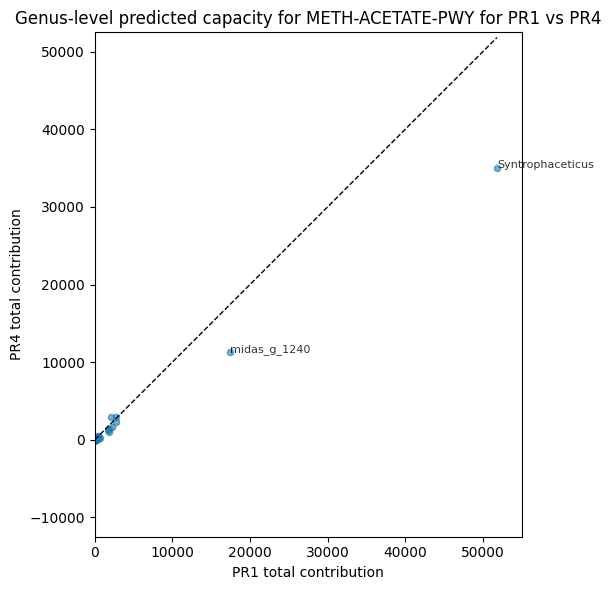

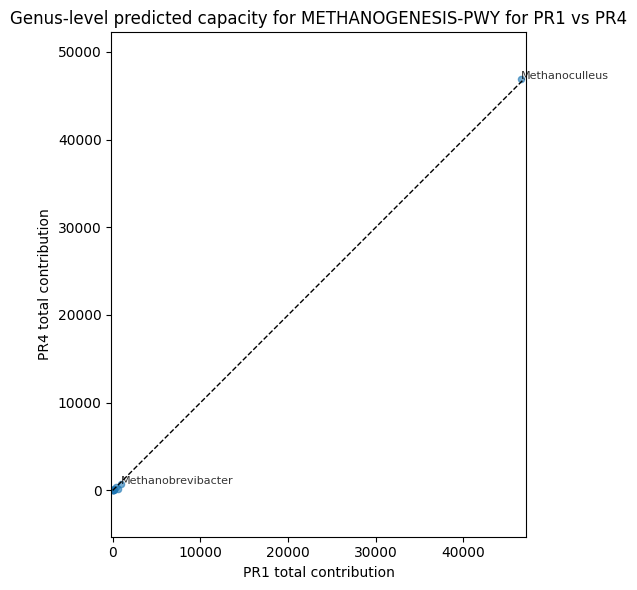

In [9]:
### Genus-level comparison of pathway abundances between PR1 and PR4



## Acetoclastic methanogenesis ##

# Genus level pathway abundance for acetoclastic methanogenesis
PR1_sub_ace = PR1_abun_genus[PR1_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()
PR4_sub_ace = PR4_abun_genus[PR4_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()


# Ensure the two columns exist and are numeric
merged_ace = PR1_sub_ace.merge(PR4_sub_ace, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_ace[c] = pd.to_numeric(merged_ace[c], errors='coerce').fillna(0)


# Scatterplot
plt.figure(figsize=(6,6))
x = merged_ace['total_contribution_PR1'].to_numpy()
y = merged_ace['total_contribution_PR4'].to_numpy()
top = merged_ace.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level predicted capacity for METH-ACETATE-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, 55000); plt.ylim(0, 40000)
plt.tight_layout(); plt.show()




## Hydrogenotrophic methanogenesis ##

# Genus level pathway abundance for hydrogenotrophic methanogenesis
PR1_sub_hyd = PR1_abun_genus[PR1_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()
PR4_sub_hyd = PR4_abun_genus[PR4_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()


# Ensure the two columns exist and are numeric
merged_hyd = PR1_sub_hyd.merge(PR4_sub_hyd, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_hyd[c] = pd.to_numeric(merged_hyd[c], errors='coerce').fillna(0)


# Scatterplot
plt.figure(figsize=(6,6))
x = merged_hyd['total_contribution_PR1'].to_numpy()
y = merged_hyd['total_contribution_PR4'].to_numpy()
top = merged_hyd.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level predicted capacity for METHANOGENESIS-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, m); plt.ylim(0, m)
plt.tight_layout(); plt.show()


In [ ]:
### Top contributing genera for METH-ACETATE-PWY and METHANOGENESIS-PWY

top15_PR1_ace = PR1_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_ace = PR4_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR1_hyd = PR1_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_hyd = PR4_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()


print('The top 15 contributing genera for acetoclastic methanogenesis in PR1 are ' + ', '.join(top15_PR1_ace['genus'].tolist()))
print('The top 15 contributing genera for acetoclastic methanogenesis in PR4 are ' + ', '.join(top15_PR4_ace['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are ' + ', '.join(top15_PR1_hyd['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are ' + ', '.join(top15_PR4_hyd['genus'].tolist()))


The top 15 contributing genera for acetoclastic methanogenesis in PR1 are Syntrophaceticus, midas_g_1240, midas_g_4921, midas_g_90696, Romboutsia, midas_g_92005, Moorella, Paeniclostridium, Terrisporobacter, midas_g_93804, Desulfitibacter, midas_g_93820, midas_g_917, midas_g_91516, midas_g_5068
The top 15 contributing genera for acetoclastic methanogenesis in PR4 are Syntrophaceticus, midas_g_1240, midas_g_92005, midas_g_90696, midas_g_4921, Romboutsia, Paeniclostridium, Terrisporobacter, Moorella, midas_g_93820, midas_g_3406, Desulfitibacter, midas_g_99090, midas_g_93804, midas_g_917
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are Methanoculleus, Methanobrevibacter, Methanobacterium, Methanothermobacter, Methanosphaera, Methanosarcina, Ca_Methanofastidiosum, Methanocorpusculum, Methanothrix, Methanospirillum, Methanomethylovorans
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are Methanoculleus, Methanobrevibacter, Methanothermo

: 

In [ ]:
### Time-series pathway abundance

# Merging data
df = df_path_abun.merge(df_meta, left_on='sample', right_on='Barcode ', how='left').copy()


# Numeric values
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0)


# Convert date to datetime format
df['Date'] = pd.to_datetime(df['SampleDate'], format='%m/%d/%Y').copy()


# Collapse to sample (instead of ASV)
df_col = (
    df
    .groupby(['sample', 'function'], as_index=False)['taxon_function_abun']
    .sum()
    .rename(columns={'taxon_function_abun': 'function_abun'})
).copy()


# Add date column to df_col
df_col = df_col.merge(df[['sample', 'SampleDate']], on='sample', how='left').copy()

In [ ]:
print(df_col.head())

      sample                                function  function_abun
0  barcode01                              1CMET2-PWY   25737.045593
1  barcode01  3-HYDROXYPHENYLACETATE-DEGRADATION-PWY     271.146183
2  barcode01                      ALL-CHORISMATE-PWY       1.252555
3  barcode01                        ANAEROFRUCAT-PWY   39941.481681
4  barcode01                       ANAGLYCOLYSIS-PWY   52175.786099
